## DPP Sampling Overview

Determinantal Point Process (DPP) sampling is a method for selecting a subset of data points such that the selected points are as **diverse** as possible. It uses the kernel matrix to measure pairwise similarities and assigns probabilities to subsets of points based on their diversity. The sampling process favors subsets with higher diversity, ensuring that the selected points are more spread out in the feature space. 

### Example

We can construct a data matrix called V with N data points in d dimensions. V has dimensions (d x N).

We can now perform DPP sampling of V using a linear similarity kernel L = V^T V. 

The original data points are columns in V. The dimensions of the L kernel is (N x N). This is equivalent to a Gram Matrix: https://en.wikipedia.org/wiki/Gram_matrix

The DPP sample looks for subsets of the N points with high diversity. The sampling probability for subsets is constructed from the determinants of their corresponding minors in the kernel matrix.


### How Determinants of the Minors of \( L \) Are Related to the Original Vectors

In the context of **Determinantal Point Processes (DPP)**, the determinant of the minors of the kernel matrix \( L \) is used to capture the **diversity** of the selected data points. The kernel matrix \( L \) encodes the pairwise similarity (or inner product) between the data points, and by computing determinants of minors of \( L \), you are measuring how well a subset of points "spans" the data space.

#### Kernel Matrix
The kernel matrix \( L \) is typically computed as either:

- \( L = V^T V \) (in the **primal form**), or
- \( L = V V^T \) (in the **dual form**),

where \( V \) is a matrix whose columns represent the data points. Each element \( L[i,j] \) is a measure of similarity between data points \( i \) and \( j \).

#### Determinant of a Minor
A **minor** of a matrix is the determinant of a smaller submatrix, which is obtained by deleting one or more rows and columns. In this case, when you compute the determinant of a minor of the kernel matrix \( L \), you are measuring the **"volume"** of the subspace spanned by the corresponding data points. The determinant reflects how linearly independent and diverse those data points are in the space.

#### Relation to Vectors
For a given subset of points, the determinant of the corresponding minor matrix quantifies the **volume** of the parallelepiped spanned by the corresponding vectors (data points) in the feature space. 

- If the vectors are more linearly independent, the determinant will be higher, meaning that the subset of points is more diverse.
- Conversely, if the vectors are highly dependent (i.e., they are close to being collinear), the determinant will be small or zero, indicating a lack of diversity.

Thus, the determinant of the minor gives an indication of how much diversity is present in a given subset of data points.


# Manual Linear Kernel DPP example
This is computationally inefficient but serves as a basic example to understand the process.

We use data V with dimensions (d x N) = (2 x 4). The original 4 data points are columns in V. The dimensions of the L kernel is (N x N) = (4 x 4).

The max possible sample size from the DPP sampling is the rank of the Kernel. The rank of the Gram Matrix is 2 in this case.

We make two of the points identical and notice that the sampling probability for the subset containing these two points is zero.

In [65]:
# Import packages
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from itertools import combinations
from numpy.linalg import matrix_rank
sns.set_style('darkgrid')
%matplotlib inline

In [66]:
# Control the data size (d = 2, N = 4 in this case)
d = 2 # Number of dimensions / features
N = 4 # Number of observations / data points

print(f'Using example of N = {N} data points in d = {d} dimensions')

# Generate a random matrix with dimensions (d x N)
np.random.seed(42)


np.random.seed(42)  # Setting seed for reproducibility
V = np.random.uniform(-5, 5, (d, N))  # 2D space, 4 points

# Make two of the points identical by duplicating a point
V[:, 2] = V[:, 0]

print(V)

# Define a V matrix (d x N): d = 2 dimensions, N = 4 data points
# Compute the primal kernel matrix (L = V.T @ V)
# This is the standard DPP approach, which samples data points based 
# on the volume spanned by their vectors.
L = V.T @ V
rank = matrix_rank(L)

print("\nPrimal kernel matrix L with dimension (N x N):")
print('L dimension:', L.shape)
print('L rank:', rank)

# Define a function to compute the determinant of minors
def compute_determinant(subset, kernel_matrix):
    """Compute the determinant of the minor matrix corresponding to the subset."""
    sub_matrix = kernel_matrix[np.ix_(subset, subset)] # Find the minor corresponding to the subset
    return np.linalg.det(sub_matrix)

# Get all possible subsets of data points
N = L.shape[0]
all_subsets = []
for k in range(1, N + 1):  # Avoid the empty set
    all_subsets.extend(combinations(range(N), k))

# Compute the determinant and probability for each subset
determinants = {}
total_determinant_sum = 0

for subset in all_subsets:
    det = compute_determinant(subset, L)
    determinants[subset] = det
    total_determinant_sum += det

# Normalize to get probabilities
probabilities = {subset: det / total_determinant_sum for subset, det in determinants.items()}

# Perform sampling (choose a subset based on probabilities)
# Convert probabilities to a cumulative distribution 
cumulative_probs = np.cumsum(list(probabilities.values()))

# Generate a random value between 0 and 1
random_value = np.random.uniform(0, 1)

# Find the subset corresponding to the random value
sampled_subset = None
for i, subset in enumerate(probabilities.keys()):
    if random_value <= cumulative_probs[i]:
        sampled_subset = subset
        break
sample_prob_value = probabilities[sampled_subset]        
print(f"\nSampled subset of data points: {sampled_subset}")
print(f"Probability of the subset: {sample_prob_value:.4f}")

# Find the subset with the highest probability
max_prob_subset = max(probabilities, key=probabilities.get)
max_prob_value = probabilities[max_prob_subset]
# Print the highest probability subset and its probability
print(f"\nSubset with the highest probability: {max_prob_subset}")
print(f"Probability of the highest probability subset: {max_prob_value:.4f}")

# Sort probabilities by the value, in descending order
sorted_probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

# Format the output for better readability, only printing subsets with size <= rank of L
print("\nAll subset probabilities (sorted by largest probability):")
for subset, prob in sorted_probabilities:
    # Check if the size of the subset is less than or equal to the rank of L
    if len(subset) <= rank:
        subset_str = ', '.join(map(str, subset))  # Convert tuple to a string representation
        print(f"Subset {subset_str}: Probability {prob:.4f}")
        
print(f'\n*Comment* \nPoint 0 and 2 are identicial. Notice that the probability of sampling them together is zero')        


Using example of N = 4 data points in d = 2 dimensions
[[-1.25459881  4.50714306 -1.25459881  0.98658484]
 [-3.4398136  -3.4400548  -3.4398136   3.66176146]]

Primal kernel matrix L with dimension (N x N):
L dimension: (4, 4)
L rank: 2

Sampled subset of data points: (1, 2)
Probability of the subset: 0.3123

Subset with the highest probability: (1, 3)
Probability of the highest probability subset: 0.3148

All subset probabilities (sorted by largest probability):
Subset 1, 3: Probability 0.3148
Subset 0, 1: Probability 0.3123
Subset 1, 2: Probability 0.3123
Subset 1: Probability 0.0256
Subset 3: Probability 0.0114
Subset 0: Probability 0.0107
Subset 2: Probability 0.0107
Subset 0, 3: Probability 0.0011
Subset 2, 3: Probability 0.0011
Subset 0, 2: Probability 0.0000

*Comment* 
Point 0 and 2 are identicial. Notice that the probability of sampling them together is zero


# Simulate imbalanced data
Now we make an example with a larger and more complex imbalanced dataset.

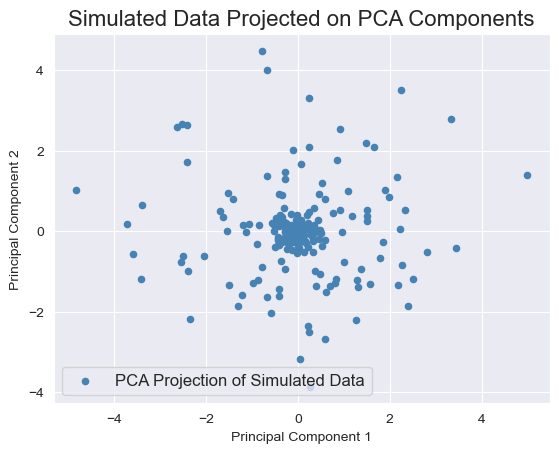

Simulated data (X) shape  [N,d]  (200, 10)
Input matrix (V) shape    [d,N]  (10, 200)


In [45]:
# Set seed
np.random.seed(42)

# Simulated the data as two gaussian distributions with same mean but different variances.
# Simulate 100 observations from each gaussian in 10 dimensions.
X_outer = np.random.normal(0, 5, size=(100,10)) # 100 points from the high variance gaussian
X_inner = np.random.normal(0, 1, size=(100,10)) # 100 points from the low variance gaussian
X = np.concatenate([X_outer,X_inner]) # Combine the samples

# Scale the data 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# PCA decomposition to reduce dimensionality (used for plotting)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plotting the first two principal components
plt.title('Simulated Data Projected on PCA Components', fontsize=16)
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=20, label='PCA Projection of Simulated Data', color='steelblue')
plt.legend(fontsize=12)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Optionally plot the two first dimensions of X
#plt.figure()
#plt.title('Simulated Imbalanced Population',fontsize=16)
#plt.scatter(X[:,0],X[:,1],s=20,label='Simulated Data',color='steelblue')
#plt.legend(fontsize=12);

V = X.T # in DPP the input vector matrix V is typically with N as columns as d as rows

print('Simulated data (X) shape  [N,d] ',X.shape)
print('Input matrix (V) shape    [d,N] ',V.shape)

# Linear Kernel DPP sample
We now use the DPPY package for sampling.

We perform DPP sampling using a linear kernel. The original 200 data points are columns in V.

The max possible sample size from the Linear Kernel DPP sampling is the rank of the Kernel. The rank of the Gram Matrix is 10 in this case.

The DPPY package can use the Dual formulation of DPP for efficient sampling when d << N. The dual formulation is described in this paper: http://proceedings.mlr.press/v99/derezinski19a.html


L shape (200, 200)
Linear Kernel Rank: 10


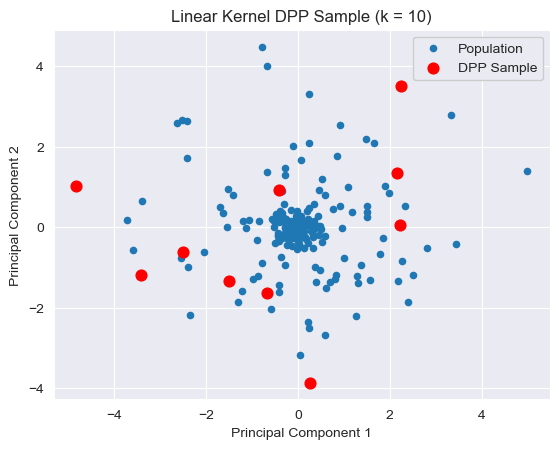

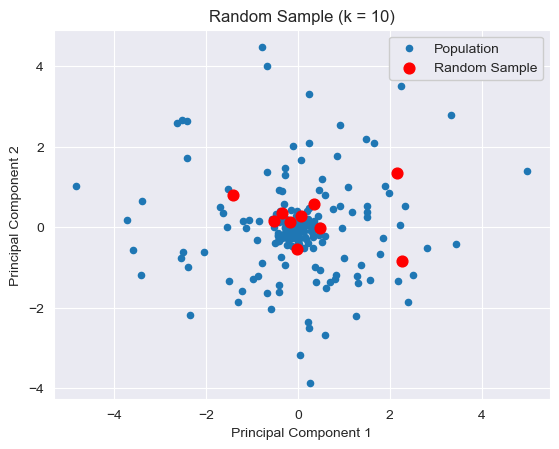

In [62]:
# Use the dppy package for efficient DPP sampling.
from dppy.finite_dpps import FiniteDPP

L = V.T @ V # Linear kernel / Gram Matrix
rank = matrix_rank(L)
print('L shape',L.shape)
print('Linear Kernel Rank:',rank)

# Sample size
k = rank

DPP = FiniteDPP(kernel_type='likelihood',                   
                                projection=False,
                                **{'L': L},
                                mode='GS')

# Optionally make DPPY use the dual formulation if d<N
#DPP = FiniteDPP(kernel_type='likelihood',
#                                projection=False,
#                                **{'L_gram_factor': V}) 



DPP.flush_samples()

# Optionally use a standard DPP sample, which does not control the size of the sample
#DPP.sample_exact(mode='GS', random_state=0) #

# Fixed size DPP sample (k-DPP)
DPP.sample_exact_k_dpp(size=k,random_state=1)
sample = np.asarray(DPP.list_of_samples)
sample = sample.ravel()

# Random sample
random = np.random.choice(X.shape[0],k) 

# Plot results of DPP sample compared to random sampling
s=20
plt.figure()
plt.title(f'Linear Kernel DPP Sample (k = {k})')
plt.scatter(X_pca[:,0],X_pca[:,1],s=s,label='Population')
plt.scatter(X_pca[sample,0],X_pca[sample,1],color='red',s=s*3,label='DPP Sample')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(framealpha=1);

plt.figure()
plt.title(f'Random Sample (k = {k})')
plt.scatter(X_pca[:,0],X_pca[:,1],s=s,label='Population')
plt.scatter(X_pca[random,0],X_pca[random,1],color='red',s=s*3,label='Random Sample')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(framealpha=1);

## DPP with RBF kernel
The max sample size is the rank of our kernel. We can use a different kernel to get a higher rank, and thus higher sample size. Here we use the radial basis function kernel to obtain a larger DPP sample.

L shape (200, 200)
RBF Kernel Rank: 200


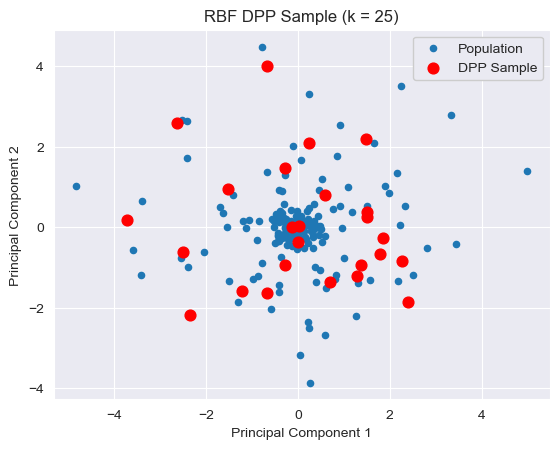

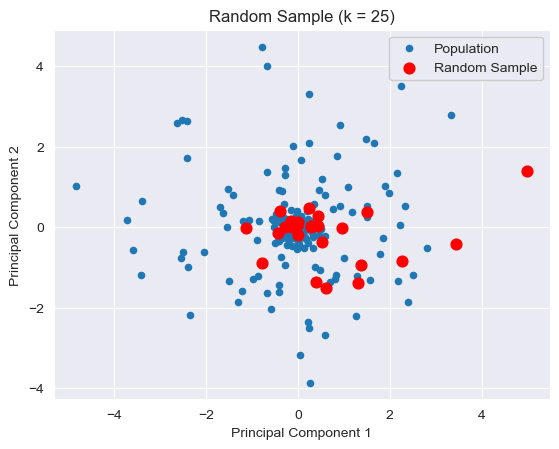

In [57]:
from sklearn.metrics.pairwise import rbf_kernel
from numpy.linalg import matrix_rank
L = rbf_kernel(X, Y=None, gamma=None) # RBF kernel
rank = matrix_rank(L)
print('L shape',L.shape)
print('RBF Kernel Rank:',rank)

k = 25

DPP = FiniteDPP(kernel_type='likelihood',                   
                                projection=False,
                                **{'L': L},
                                mode='GS')
DPP.flush_samples()
DPP.sample_exact_k_dpp(size=k,random_state=0)
sample = np.asarray(DPP.list_of_samples)
sample = sample.ravel()
random = np.random.choice(X.shape[0],k)

s=20
plt.figure()
plt.title(f'RBF DPP Sample (k = {k})')
plt.scatter(X_pca[:,0],X_pca[:,1],s=s,label='Population')
plt.scatter(X_pca[sample,0],X_pca[sample,1],color='red',s=s*3,label='DPP Sample')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(framealpha=1);

plt.figure()
plt.title(f'Random Sample (k = {k})')
plt.scatter(X_pca[:,0],X_pca[:,1],s=s,label='Population')
plt.scatter(X_pca[random,0],X_pca[random,1],color='red',s=s*3,label='Random Sample')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(framealpha=1);